# 1. Introduction
### I'm using a dataset found on Kaggle (https://www.kaggle.com/gauthamp10/google-playstore-apps) that was scraped from the Google Play Store.  When deciding what types of apps to invest in or develop, you'll want to consider which show the potential for profit.  My goal is to find two types of data:
### 1. Apps that have the current highest profitablily and share common features.  This category of apps will represent a reliable return, albeit in a possibly impacted market of similar apps.
### 2. Categories of app, within which there has not been a great deal of development, representing a potentially riskier investment yet with less competition.  

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import time

import itertools
from itertools import combinations

import scipy as sp
from scipy.stats import pearsonr, chi2_contingency

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

from datetime import datetime
from dateutil import relativedelta

from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_colwidth = None
pd.options.display.max_rows = None

import statsmodels.api as sm 
from statsmodels.graphics.api import abline_plot # For visualling evaluating predictions.
from statsmodels.stats.proportion import proportion_confint

# from catboost import Pool, CatBoostClassifier (maybe I'll include this?)

import warnings # For handling error messages.
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

import sklearn.metrics as met
from sklearn import linear_model, preprocessing, svm, datasets
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, RFE
from sklearn.linear_model import LassoCV, LogisticRegression, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale, StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import lightgbm
from bayes_opt import BayesianOptimization
from catboost import CatBoostClassifier, cv, Pool

# 2. Importing Data
### A preliminary glance of the CSV data showed that there are millions of loans, though the only ones of interest are the accepted loans that were 'Fully Paid', 'Charged Off'' in the 'loan_status' column.  To save some time, the unique 'id' column was set to the index.  According to Lending Club:


In [2]:
df = pd.read_csv('Google-Playstore.csv', index_col ='App Id') 

In [3]:
df.head()

,App Name,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice
App Id,,,,,,,,,,,,,,,,,,,,,,
com.httrack.android,HTTrack Website Copier,Communication,3.6,2848.0,"100,000+",100000.0,351560,True,0.0,USD,2.7M,2.3 and up,Xavier Roche,http://www.httrack.com/,roche+android@httrack.com,"Aug 12, 2013","May 20, 2017",Everyone,http://android.httrack.com/privacy-policy.html,False,False,False
com.skizze.wwii,World War 2: Offline Strategy,Strategy,4.3,17297.0,"1,000,000+",1000000.0,2161778,True,0.0,USD,86M,5.1 and up,Skizze Games,http://stereo7.com/,Skizze.Games@gmail.com,"Jul 19, 2018","Nov 26, 2020",Everyone 10+,https://www.iubenda.com/privacy-policy/8032781,True,True,False
com.themausoft.wpsapp,WPSApp,Tools,4.2,488639.0,"50,000,000+",50000000.0,79304739,True,0.0,USD,5.8M,4.1 and up,TheMauSoft,http://www.themausoft.com,wpsapp.app@gmail.com,"Mar 7, 2016","Oct 21, 2020",Everyone,https://sites.google.com/view/wpsapppolicy/main,True,False,False
com.mobisystems.office,"OfficeSuite - Office, PDF, Word, Excel, PowerPoint",Business,4.2,1224420.0,"100,000,000+",100000000.0,163660067,True,0.0,USD,59M,4.4 and up,MobiSystems,http://www.mobisystems.com,support-officesuite-android@mobisystems.com,"Dec 22, 2011","Nov 23, 2020",Everyone,http://www.mobisystems.com/mobile/privacy-policy.html,True,True,False
com.arthelion.loudplayer,Loud Player Free,Music & Audio,4.2,665.0,"50,000+",50000.0,73463,True,0.0,USD,29M,5.0 and up,Arthelion92,http://www.arthelion.com,arthelion92@gmail.com,"Sep 24, 2016","Nov 22, 2020",Everyone,http://www.arthelion.com/index.php/fr/android-fr/loudplayer-declaration-de-confidentialite,False,False,False


In [4]:
df.tail()

,App Name,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice
App Id,,,,,,,,,,,,,,,,,,,,,,
com.fleetenable.app,FleetEnable,Productivity,NaN,NaN,10+,10.0,10,True,0.0,USD,Varies with device,Varies with device,Imaginnovate,http://fleetenable.com/,krishna@imaginnovate.com,NaN,"Jun 30, 2020",Everyone,http://fleetenable.com/,False,False,False
com.fleetenable.autothink,AutoThink,Productivity,0.0,0.0,100+,100.0,127,True,0.0,USD,4.7M,4.1 and up,Imaginnovate,http://www.imaginnovate.com,krishna@imaginnovate.com,"Nov 26, 2019","Nov 13, 2020",Everyone,http://www.imaginnovate.com,False,False,False
com.fieldenable.app.fieldenable,FieldEnable,Business,0.0,0.0,100+,100.0,282,True,0.0,USD,28M,5.0 and up,Imaginnovate,http://www.imaginnovate.com,FieldEnable@imaginnovate.com,"Apr 30, 2018","Nov 30, 2020",Everyone,http://tw.fieldenable.com/privacy,False,False,False
com.varbin.liveconcert,Live Concert,Events,0.0,0.0,500+,500.0,986,True,0.0,USD,8.1M,4.1 and up,Varbin Softwares,http://varbin.com,varbinsoftware@gmail.com,"Dec 20, 2017","Dec 20, 2017",Everyone,http://varbin.com/live-concert-privacy-policy,False,False,False
com.varbin.rajputindia,Rajput India,Social,4.6,81.0,"10,000+",10000.0,18892,True,0.0,USD,8.8M,4.1 and up,Varbin Softwares,http://varbin.com,rajputindia2017@gmail.com,"Jun 15, 2017","Sep 27, 2018",Teen,NaN,True,False,False


# We have an index, 21 columns, and 1.1M rows.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1118136 entries, com.httrack.android to com.varbin.rajputindia
Data columns (total 22 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   App Name           1118135 non-null  object 
 1   Category           1118133 non-null  object 
 2   Rating             1111286 non-null  float64
 3   Rating Count       1111286 non-null  float64
 4   Installs           1117975 non-null  object 
 5   Minimum Installs   1117975 non-null  float64
 6   Maximum Installs   1118136 non-null  int64  
 7   Free               1118136 non-null  bool   
 8   Price              1118136 non-null  float64
 9   Currency           1117975 non-null  object 
 10  Size               1118136 non-null  object 
 11  Minimum Android    1116123 non-null  object 
 12  Developer Id       1118134 non-null  object 
 13  Developer Website  703770 non-null   object 
 14  Developer Email    1118114 non-null  object 
 15  Rele

# We confirm that every index value is unique.

In [6]:
df.index.nunique()

1118136

# Some summary stats.

In [7]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
App Name,1118135,1046869,Tic Tac Toe,143,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Category,1118133,48,Education,115242,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rating,1.11129e+06,NaN,NaN,NaN,2.49033,2.05397,0,0,3.6,4.3,5
Rating Count,1.11129e+06,NaN,NaN,NaN,5159.63,272409,0,0,11,100,1.25381e+08
Installs,1117975,22,"1,000+",198309,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Minimum Installs,1.11798e+06,NaN,NaN,NaN,313643,2.04394e+07,0,100,1000,10000,1e+10
Maximum Installs,1.11814e+06,NaN,NaN,NaN,544453,3.03106e+07,0,160,1719,19116,1.07727e+10
Free,1118136,2,True,1071333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,1.11814e+06,NaN,NaN,NaN,0.205073,3.54101,0,0,0,0,400
Currency,1117975,54,USD,1075136,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Some features don't add any useful information for us at this time

In [8]:
df.drop(['Developer Website','Developer Id','Privacy Policy', 'Developer Email','Free', 'Minimum Installs', 'Installs'],axis=1,inplace=True)

In [9]:
df.drop(['App Name'],axis=1,inplace=True)

# Rating and release information is too important to our data, so we'll drop the rows with missing values.  Only a small portion are NaN.

In [10]:
df.isnull().sum().sort_values()

Maximum Installs       0
Price                  0
Size                   0
Last Updated           0
Content Rating         0
Ad Supported           0
In App Purchases       0
Editors Choice         0
Category               3
Currency             161
Minimum Android     2013
Rating              6850
Rating Count        6850
Released            7730
dtype: int64

In [11]:
df = df.dropna()

# OS version is applicable, but I'll leave "Varies with device" and the version ranges as 0 since there are so many.

In [12]:
df['Minimum Android'].value_counts()

4.1 and up            344074
4.4 and up            165508
5.0 and up            137942
4.0.3 and up          117892
4.0 and up             89262
4.2 and up             60330
2.3 and up             41896
6.0 and up             23556
4.3 and up             20807
5.1 and up             15232
Varies with device     15017
2.2 and up             14804
2.3.3 and up           12847
3.0 and up             10230
7.0 and up              9092
2.1 and up              8402
1.6 and up              5386
4.4W and up             5191
8.0 and up              3426
2.0 and up              1788
3.2 and up              1587
1.5 and up              1422
3.1 and up               910
7.1 and up               667
2.0.1 and up             323
1.0 and up               215
1.1 and up               137
4.0.3 - 8.0               23
4.0 - 8.0                 22
4.0 - 6.0                 21
2.2 - 2.3.4               16
2.3 - 6.0                 13
2.3 - 5.0                 11
4.1 - 7.1.1               10
4.1 - 6.0     

In [13]:
df['Minimum Android'][df['Minimum Android'].str.contains(' - ')] = '0'
df['Minimum Android'] = df['Minimum Android'].str.replace('Varies with device','0').str.replace('[a-zA-Z]','')
df['Minimum Android'] = df['Minimum Android'].str[:3] + df['Minimum Android'].str[4:]
df['Minimum Android'] = pd.to_numeric(df['Minimum Android'])

In [14]:
df['Minimum Android'].value_counts()

4.10    344074
4.40    170700
5.00    137943
4.03    117892
4.00     89262
4.20     60330
2.30     41896
6.00     23558
4.30     20808
0.00     15390
5.10     15233
2.20     14805
2.33     12847
3.00     10230
7.00      9093
2.10      8402
1.60      5386
8.00      3429
2.00      1788
3.20      1587
1.50      1422
3.10       910
7.10       667
2.01       323
1.00       215
1.10       137
Name: Minimum Android, dtype: int64

# We'll convert Size to numbers and also leave "Varies with device" as 0.

In [15]:
df['Size'].value_counts()

Varies with device    30465
11M                   29333
12M                   26418
13M                   22864
14M                   21651
16M                   20720
15M                   19221
10M                   16238
17M                   15977
18M                   14590
19M                   13421
20M                   12791
21M                   12391
22M                   12037
24M                   11546
23M                   11423
25M                   11037
26M                   10327
4.0M                   9920
3.9M                   9673
3.8M                   9586
3.7M                   9527
27M                    9456
3.5M                   9291
3.6M                   9108
28M                    9060
4.1M                   9052
3.4M                   9021
4.2M                   8980
4.3M                   8863
31M                    8588
3.3M                   8510
29M                    8498
4.4M                   8370
4.9M                   8196
5.6M                

In [16]:
df['Size'] = df['Size'].str.replace(',','').str.replace('Varies with device','00')
df['SizeLetter'] = df['Size'].str[-1:]
df['SizeLetter'] = pd.to_numeric(df['SizeLetter'].str.replace('M','1000000').str.replace('k','1000').str.replace('G','1000000000'))
df['Size'] = pd.to_numeric(df['Size'].str.replace('[a-zA-Z]',''))
df['Size'] = df['Size']*df['SizeLetter']
df.drop(['SizeLetter'],axis=1,inplace=True)

In [17]:
df['Size'].value_counts()

0.000000e+00    30465
1.100000e+07    29333
1.200000e+07    26418
1.300000e+07    22864
1.400000e+07    21651
1.600000e+07    20720
1.500000e+07    19221
1.000000e+07    17965
1.700000e+07    15977
1.800000e+07    14590
1.900000e+07    13421
2.000000e+07    12791
2.100000e+07    12391
2.200000e+07    12037
2.400000e+07    11546
2.300000e+07    11423
2.500000e+07    11037
2.600000e+07    10327
4.000000e+06     9920
3.900000e+06     9673
3.800000e+06     9586
3.700000e+06     9527
2.700000e+07     9456
3.500000e+06     9291
3.600000e+06     9108
2.800000e+07     9060
4.100000e+06     9052
3.400000e+06     9021
4.200000e+06     8980
4.300000e+06     8863
3.100000e+07     8588
3.300000e+06     8510
2.900000e+07     8498
4.400000e+06     8370
4.900000e+06     8196
5.600000e+06     8113
4.800000e+06     8098
3.000000e+07     7991
4.700000e+06     7990
3.200000e+06     7972
5.000000e+06     7840
4.500000e+06     7809
5.200000e+06     7661
4.600000e+06     7609
3.200000e+07     7572
3.000000e+

# Category is fine.

In [18]:
df['Category'].value_counts()

Education                  114690
Music & Audio              104165
Entertainment               81766
Books & Reference           78677
Personalization             73230
Tools                       67950
Lifestyle                   54355
Business                    41707
Health & Fitness            31169
Productivity                29945
Photography                 28851
Travel & Local              25692
Finance                     24600
Puzzle                      24533
Food & Drink                24060
Sports                      21875
News & Magazines            21467
Shopping                    20287
Casual                      19916
Communication               18178
Arcade                      17300
Social                      16845
Simulation                  15044
Medical                     12409
Action                      12307
Art & Design                12253
Educational                 11262
Maps & Navigation           10325
Adventure                    9995
Video Players 

# Unrated can be dropped since it's so few.  There are also very few 'Adults only 18+'; I'll combine it with 'Mature 17+' since they're so similar.

In [19]:
df['Content Rating'].value_counts()

Everyone           959893
Teen                98860
Mature 17+          31721
Everyone 10+        17735
Unrated                66
Adults only 18+        52
Name: Content Rating, dtype: int64

In [20]:
df = df[df['Content Rating'] != 'Unrated']
df['Content Rating'] = df['Content Rating'].str.replace('Everyone 10+','10').str.replace('Everyone','0').str.replace('Teen','13').str.replace('Adults only 18+','17').str.replace('\D','')

In [21]:
df['Content Rating'] = pd.to_numeric(df['Content Rating'])

In [22]:
df['Content Rating'].value_counts()

0     959893
13     98860
17     31773
10     17735
Name: Content Rating, dtype: int64

# I'll drop the non USD currencies.

In [23]:
df['Currency'].value_counts()

USD    1066500
XXX      41089
EUR        117
INR        101
PKR         53
BRL         39
TRY         38
GBP         35
RUB         29
VND         18
HKD         17
IDR         16
JPY         15
BDT         13
CAD         13
CHF         12
ILS         11
SGD         10
UAH          9
KRW          9
AED          9
NGN          8
BGN          7
AUD          7
THB          6
NOK          5
PLN          5
SEK          5
COP          5
SAR          5
EGP          4
MXN          4
LKR          4
PHP          4
CZK          4
RON          3
PEN          3
ZAR          3
TWD          3
LBP          2
DKK          2
CLP          2
MYR          2
NZD          2
KES          2
GHS          2
HUF          2
BOB          1
TZS          1
CRC          1
RSD          1
KZT          1
DZD          1
HRK          1
Name: Currency, dtype: int64

In [24]:
df = df[df['Currency'].str.contains('USD')]
df.drop(['Currency'],axis=1,inplace=True)

# We'll drop the apps that have never been rated, even though it's about half our dataset, since we're mostly interested in how much users liked the apps.

In [25]:
df['Rating Count'].value_counts()

0.0            399157
5.0             27057
6.0             23228
7.0             19905
8.0             17511
9.0             15739
10.0            13880
11.0            12748
12.0            11402
13.0            10540
14.0             9764
15.0             9094
16.0             8356
17.0             7811
18.0             7509
19.0             6933
20.0             6760
21.0             6305
22.0             5980
23.0             5606
24.0             5418
25.0             5151
27.0             4856
26.0             4677
28.0             4347
29.0             4298
30.0             4132
31.0             4064
32.0             3937
33.0             3598
34.0             3561
35.0             3437
36.0             3372
37.0             3186
38.0             3146
39.0             3062
40.0             2951
41.0             2823
42.0             2802
43.0             2754
44.0             2688
45.0             2614
46.0             2531
48.0             2412
50.0             2312
47.0      

In [26]:
df = df[df['Rating Count'] != 0]

In [27]:
df['Rating Count'].value_counts()

5.0            27057
6.0            23228
7.0            19905
8.0            17511
9.0            15739
10.0           13880
11.0           12748
12.0           11402
13.0           10540
14.0            9764
15.0            9094
16.0            8356
17.0            7811
18.0            7509
19.0            6933
20.0            6760
21.0            6305
22.0            5980
23.0            5606
24.0            5418
25.0            5151
27.0            4856
26.0            4677
28.0            4347
29.0            4298
30.0            4132
31.0            4064
32.0            3937
33.0            3598
34.0            3561
35.0            3437
36.0            3372
37.0            3186
38.0            3146
39.0            3062
40.0            2951
41.0            2823
42.0            2802
43.0            2754
44.0            2688
45.0            2614
46.0            2531
48.0            2412
50.0            2312
47.0            2298
51.0            2255
49.0            2234
52.0         

# Lastly, we could convert to datetimes.

In [28]:
df['Released'] = pd.to_datetime(df['Released'])
df['Last Updated'] = pd.to_datetime(df['Last Updated'])

# And we can finally set the index to the unique 'App Id' and the non-unique 'App Name'.

In [29]:
# df['App Id'] = df['App Id'].astype(str) + ' -- ' + df['App Name'].astype(str)
# df.set_index('App Id')
# df.drop(['App Name'],axis=1,inplace=True)

# And this is what we're left with.

In [30]:
df.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Category,667343,48,Education,67026,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rating,667343,NaN,NaN,NaN,NaT,NaT,4.07907,0.64579,1,3.8,4.2,4.5,5
Rating Count,667343,NaN,NaN,NaN,NaT,NaT,8252.46,325836,5,15,58,361,1.25381e+08
Maximum Installs,667343,NaN,NaN,NaN,NaT,NaT,860151,3.6272e+07,0,2458,11073,66794,1.07727e+10
Price,667343,NaN,NaN,NaN,NaT,NaT,0.153594,2.49697,0,0,0,0,399.99
Size,667343,NaN,NaN,NaN,NaT,NaT,1.88032e+07,2.32179e+07,0,4.4e+06,9.5e+06,2.5e+07,1e+09
Minimum Android,667343,NaN,NaN,NaN,NaT,NaT,4.06492,0.993809,0,4.03,4.1,4.4,8
Released,667343,3963,2020-06-16 00:00:00,556,2010-01-28,2020-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Last Updated,667343,3639,2020-11-27 00:00:00,4300,2008-10-22,2020-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Content Rating,667343,NaN,NaN,NaN,NaT,NaT,1.92181,4.76986,0,0,0,0,17


# We'll sort everything a little.

In [31]:
df.sort_values(["Category", 'Rating'], inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 667343 entries, com.fps.shooting.world.war.of.heroes to com.dvminagames.adivinamovieeljuego
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Category          667343 non-null  object        
 1   Rating            667343 non-null  float64       
 2   Rating Count      667343 non-null  float64       
 3   Maximum Installs  667343 non-null  int64         
 4   Price             667343 non-null  float64       
 5   Size              667343 non-null  float64       
 6   Minimum Android   667343 non-null  float64       
 7   Released          667343 non-null  datetime64[ns]
 8   Last Updated      667343 non-null  datetime64[ns]
 9   Content Rating    667343 non-null  int64         
 10  Ad Supported      667343 non-null  bool          
 11  In App Purchases  667343 non-null  bool          
 12  Editors Choice    667343 non-null  bool          
dtype

In [33]:
Cat = df.groupby(['Category']).count()['Rating'].sort_values(ascending=False)
LabelsCat = Cat.index
DataCat = Cat.values

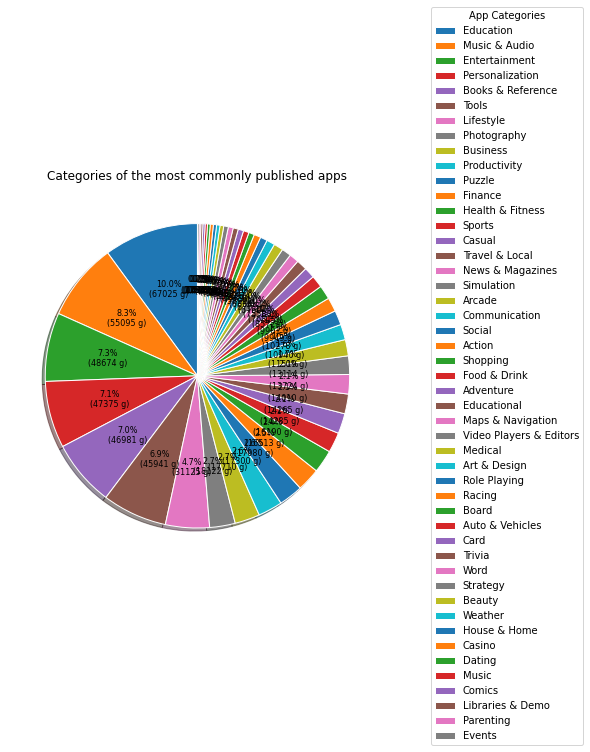

In [34]:
# Wedge properties 
wp = { 'linewidth' : 1, 'edgecolor' : "white" } 
  
# Creating autocpt arguments 
def func(pct, allvalues): 
    absolute = int(pct / 100.*np.sum(allvalues)) 
    return "{:.1f}%\n({:d} g)".format(pct, absolute) 
  
# Creating plot 
fig, ax = plt.subplots(figsize =(10, 7)) 
wedges, texts, autotexts = ax.pie(DataCat,  
                                  autopct = lambda pct: func(pct, DataCat), 
                                  shadow = True, 
                                  startangle = 90, 
                                  wedgeprops = wp, 
                                 ) 
  
# Adding legend 
ax.legend(wedges, LabelsCat, 
          title ="App Categories", 
          loc ="center left", 
          bbox_to_anchor =(1.1, 0, 0.5, 1)) 
  
plt.setp(autotexts, size = 8) 
ax.set_title("Categories of the most commonly published apps") 
  
# show plot 
plt.show() 

In [35]:
BigCat = Cat.nlargest(9)
SmallCat = pd.Series(Cat.nsmallest(39).sum(),index=['Other'])
AllCat = BigCat.append(SmallCat)
LabelsAllCat = AllCat.index
DataAllCat = AllCat.values

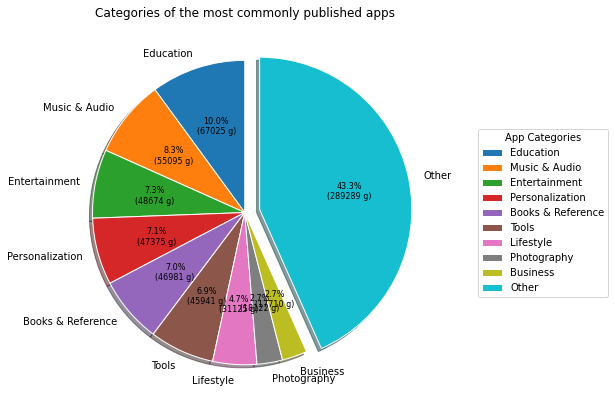

In [36]:
# Creating explode data 
explode = (0,0,0,0,0,0,0,0,0,.1) 
  
# Creating color parameters 
# colors = ( "orange", "cyan", "brown", 
#           "grey", "indigo", "beige") 
  
# Wedge properties 
# wp = { 'linewidth' : 1, 'edgecolor' : "white" } 
  
# Creating autocpt arguments 
# def func(pct, allvalues): 
#     absolute = int(pct / 100.*np.sum(allvalues)) 
#     return "{:.1f}%\n({:d} g)".format(pct, absolute) 
  
# Creating plot 
fig, ax = plt.subplots(figsize =(10, 7)) 
wedges, texts, autotexts = ax.pie(DataAllCat,  
                                  autopct = lambda pct: func(pct, DataAllCat), 
                                  explode = explode,  
                                  labels = LabelsAllCat, 
                                  shadow = True, 
#                                   colors = colors, 
                                  startangle = 90, 
                                  wedgeprops = wp, 
#                                   textprops = dict(color ="magenta")
                                 ) 
  
# Adding legend 
ax.legend(wedges, LabelsAllCat, 
          title ="App Categories", 
          loc ="center left", 
          bbox_to_anchor =(1.1, 0, 0.5, 1)) 
  
plt.setp(autotexts, size = 8) 
ax.set_title("Categories of the most commonly published apps") 
  
# show plot 
plt.show() 

In [37]:
LabelsBigCat = BigCat.index
DataBigCat = BigCat.values

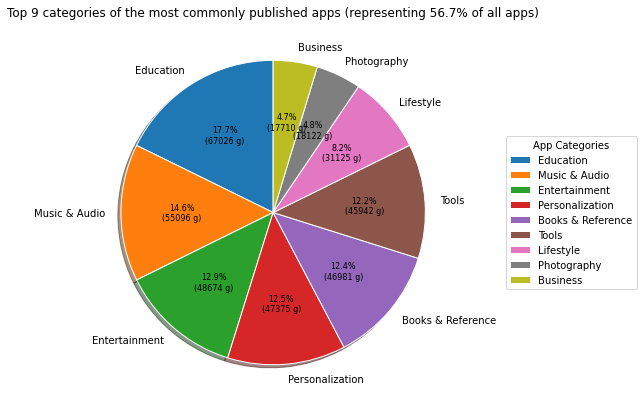

In [38]:
# Creating plot 
fig, ax = plt.subplots(figsize =(10, 7)) 
wedges, texts, autotexts = ax.pie(DataBigCat,  
                                  autopct = lambda pct: func(pct, DataBigCat), 
                                  labels = LabelsBigCat, 
                                  shadow = True, 
                                  startangle = 90, 
                                  wedgeprops = wp, 
                                 ) 
  
# Adding legend 
ax.legend(wedges, LabelsBigCat, 
          title ="App Categories", 
          loc ="center left", 
          bbox_to_anchor =(1.1, 0, 0.5, 1)) 
  
plt.setp(autotexts, size = 8) 
ax.set_title("Top 9 categories of the most commonly published apps (representing 56.7% of all apps)")  
  
# show plot 
plt.show() 

In [39]:
x = df[df['Category'].isin(LabelsBigCat)]
z = x.groupby(['Category']).count()['Rating'].index
x = x.groupby(['Category','Ad Supported']).count()['Rating']
y = x.values
y = y.reshape((9,2))

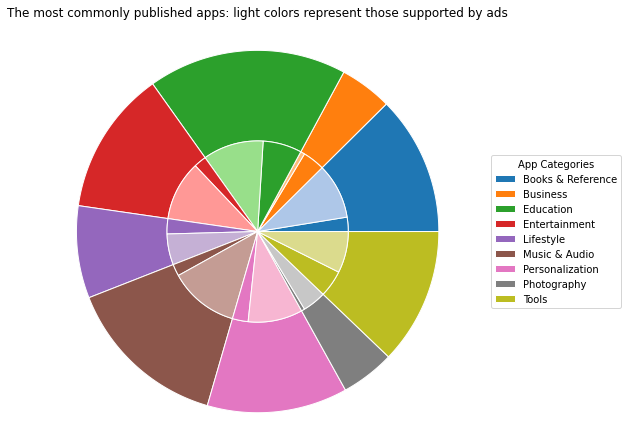

In [42]:
size=6

# Wedge properties 
wp = { 'linewidth' : 1, 'edgecolor' : "white" } 

# Creating autocpt arguments 
def func(pct, allvalues): 
    absolute = int(pct / 100.*np.sum(allvalues)) 
    return "{:.1f}%\n({:d} g)".format(pct, absolute) 

# normalizing data to 2 pi 
norm = y / np.sum(y)*2 * np.pi 
  
# obtaining ordinates of bar edges 
left = np.cumsum(np.append(0,  
                           norm.flatten()[:-1])).reshape(y.shape) 
  
# Creating color scale 
cmap = plt.get_cmap("tab20") 
outer_colors = cmap(np.arange(9)*2) 
inner_colors = cmap(np.arange(18)*1) 
  
# Creating plot 
fig, ax = plt.subplots(figsize =(10, 7), 
                       subplot_kw = dict(polar = True)) 
    
    
    
ax.bar(x = left[:, 0], 
       width = norm.sum(axis = 1), 
       bottom = 1-size, 
       height = size, 
       color = outer_colors,  
       edgecolor ='w', 
       linewidth = 1, 
       align ="edge") 
  
ax.bar(x = left.flatten(), 
       width = norm.flatten(), 
       bottom = 1-2 * size, 
       height = size, 
       color = inner_colors, 
       edgecolor ='w', 
       linewidth = 1, 
       align ="edge") 
  
    
# Adding legend 
ax.legend(wedges, z, 
          title ="App Categories", 
          loc ="center left", 
          bbox_to_anchor =(1.1, 0, 0.5, 1)) 
    
plt.setp(autotexts, size = 8) 
ax.set_title("The most commonly published apps: light colors represent those supported by ads") 
ax.set_axis_off() 

# show plot 
plt.show() 